In [1]:
import sys

import torch
import torch.nn as nn

sys.path.append("..")


In [2]:
from data.dataloader import LowLightDataModule
from model.blocks.attention import (
    SelfAttentionBlock,
    CrossAttentionBlock,
    PatchEmbedding,
    UnPatchEmbedding,
)
from model.blocks.homomorphic import HomomorphicSeparate
from utils.utils import show_batch, summarize_model


In [3]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=256,
    batch_size=1,
    num_workers=4,
)

data_module.setup(stage="fit")


In [4]:
train_dataloader = data_module.train_dataloader()


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


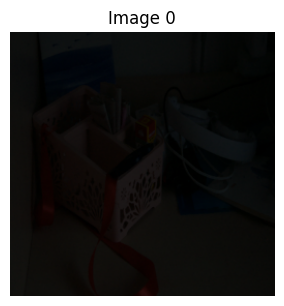

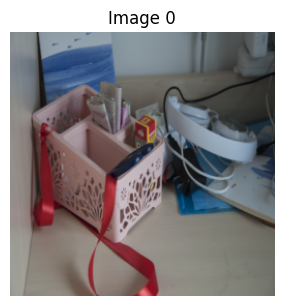

In [5]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
show_batch(images=train_low)
show_batch(images=train_high)


In [6]:
separate = HomomorphicSeparate(cutoff=0.1)


In [7]:
train_low = train_low.cuda()
separate = separate.cuda()


In [8]:
x1, x2, x3 = train_low[:, 0:1, :, :], train_low[:, 1:2, :, :], train_low[:, 2:3, :, :]
x1_il, x1_re = separate(x1)
x2_il, x2_re = separate(x2)
x3_il, x3_re = separate(x3)


In [9]:
patch = PatchEmbedding(
    in_channels=3,
    embed_dim=32,
    patch_size=1,
)
sttn = SelfAttentionBlock(
    embed_dim=32,
    num_heads=8,
    mlp_ratio=4,
    dropout_ratio=0.2,
)
cttn = CrossAttentionBlock(
    embed_dim=32,
    num_heads=8,
    mlp_ratio=4,
    dropout_ratio=0.2,
)
unpatch = UnPatchEmbedding(
    embed_dim=32,
    patch_size=1,
    out_channels=3,
)


In [10]:
patch = patch.cuda()
sttn = sttn.cuda()
cttn = cttn.cuda()
unpatch = unpatch.cuda()


In [11]:
il_concat = torch.concat(tensors=[x1_il, x2_il, x3_il], dim=1)
re_concat = torch.concat(tensors=[x1_re, x2_re, x3_re], dim=1)

il_patch = patch(il_concat)
re_patch = patch(re_concat)

il_sttn = sttn(il_patch)
re_sttn = sttn(re_patch)
out_cttn = cttn(il_sttn, re_sttn)
out_unpatch = unpatch(out_cttn)


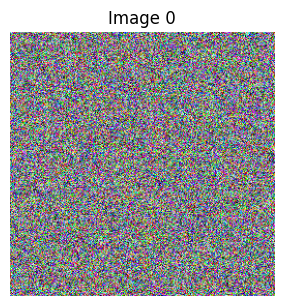

In [12]:
show_batch(images=out_unpatch)
